In [1]:
import tweepy
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from gensim import *

In [2]:
consumer_key = 'jJTx5zBxXiwzVe7wlNB1MnDc1'
consumer_secret = 'CokQHNSxYfScJDObUbkQTcVFnNfadpubrLm6TuwrOp7JgVZxHP'
access_token = '182731614-qNVpsynkbdh8PIyZWB5fibTEVUx2yDBUwKgYMflQ'
access_token_secret = 'w7ec5DlX3kLXJoVbCGWAdxgPiPVkBg46J8IStGp4oGhdw'

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)


tweets = api.search('PetrolBomb', count=200,lang='en')


data = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])

display(data.head(10))


print(tweets[0].created_at)


,Tweets
0,RT @JIYouthOfficial: Jamaat-e-Islami Youth Lah...
1,RT @JIYouthOfficial: Jamaat-e-Islami Youth Lah...
2,RT @mughalbha: PTI would introduce a new Tax A...
3,RT @mughalbha: PTI would introduce a new Tax A...
4,RT @NaeemRehmanEngr: The increment of Rs. 6 in...
5,Jamaat-e-Islami Youth Lahore organised an effe...
6,RT @NaeemRehmanEngr: The increment of Rs. 6 in...
7,RT @mughalbha: Another amnesty scheme for non-...
8,RT @mughalbha: PTI would introduce a new Tax A...
9,RT @mughalbha: Another amnesty scheme for non-...


2019-04-03 08:36:10


### 1.1 Number of Words

 The basic intuition behind this is that generally, the negative sentiments contain a lesser amount of words than the positive ones.

In [4]:
data['word_count'] = data['Tweets'].str.encode('utf-8').apply(lambda x: len(str(x).split(" ")))
data[['Tweets','word_count']].head()

,Tweets,word_count
0,RT @JIYouthOfficial: Jamaat-e-Islami Youth Lah...,20
1,RT @JIYouthOfficial: Jamaat-e-Islami Youth Lah...,20
2,RT @mughalbha: PTI would introduce a new Tax A...,23
3,RT @mughalbha: PTI would introduce a new Tax A...,23
4,RT @NaeemRehmanEngr: The increment of Rs. 6 in...,25


### 1.2 Number of characters
This feature is also based on the previous feature intuition. Here, we calculate the number of characters in each tweet. This is done by calculating the length of the tweet.

In [5]:
data['char_count'] = data['Tweets'].str.len() ## this also includes spaces
data[['Tweets','char_count']].head()

,Tweets,char_count
0,RT @JIYouthOfficial: Jamaat-e-Islami Youth Lah...,140
1,RT @JIYouthOfficial: Jamaat-e-Islami Youth Lah...,140
2,RT @mughalbha: PTI would introduce a new Tax A...,140
3,RT @mughalbha: PTI would introduce a new Tax A...,140
4,RT @NaeemRehmanEngr: The increment of Rs. 6 in...,140


### 1.3 Average word length


We will also extract another feature which will calculate the average word length of each tweet. This can also potentially help us in improving our model.

In [6]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

data['avg_word'] = data['Tweets'].apply(lambda x: avg_word(x))
data[['Tweets','avg_word']].head()

,Tweets,avg_word
0,RT @JIYouthOfficial: Jamaat-e-Islami Youth Lah...,6
1,RT @JIYouthOfficial: Jamaat-e-Islami Youth Lah...,6
2,RT @mughalbha: PTI would introduce a new Tax A...,5
3,RT @mughalbha: PTI would introduce a new Tax A...,5
4,RT @NaeemRehmanEngr: The increment of Rs. 6 in...,4


### 1.4 Number of StopWords


Generally, while solving an NLP problem, the first thing we do is to remove the stopwords. But sometimes calculating the number of stopwords can also give us some extra information which we might have been losing before.

In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['stopwords'] = data['Tweets'].apply(lambda x: len([x for x in x.split() if x in stop]))
data[['Tweets','stopwords']].head()

,Tweets,stopwords
0,RT @JIYouthOfficial: Jamaat-e-Islami Youth Lah...,5
1,RT @JIYouthOfficial: Jamaat-e-Islami Youth Lah...,5
2,RT @mughalbha: PTI would introduce a new Tax A...,2
3,RT @mughalbha: PTI would introduce a new Tax A...,2
4,RT @NaeemRehmanEngr: The increment of Rs. 6 in...,9


### 1.5 Number of special characters,Numbers & uppercase words

In [8]:
data['numerics'] = data['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data['upper'] = data['Tweets'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
data['hastags'] = data['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

In [9]:
data.head()

,Tweets,word_count,char_count,avg_word,stopwords,numerics,upper,hastags
0,RT @JIYouthOfficial: Jamaat-e-Islami Youth Lah...,20,140,6,5,0,1,0
1,RT @JIYouthOfficial: Jamaat-e-Islami Youth Lah...,20,140,6,5,0,1,0
2,RT @mughalbha: PTI would introduce a new Tax A...,23,140,5,2,1,3,0
3,RT @mughalbha: PTI would introduce a new Tax A...,23,140,5,2,1,3,0
4,RT @NaeemRehmanEngr: The increment of Rs. 6 in...,25,140,4,9,1,1,0


### 2. Basic Pre-processing
So far, we have learned how to extract basic features from text data. Before diving into text and feature extraction, our first step should be cleaning the data in order to obtain better features. We will achieve this by doing some of the basic pre-processing steps on our training data.

### 2.1 Lower case
The first pre-processing step which we will do is transform our tweets into lower case. This avoids having multiple copies of the same words. For example, while calculating the word count, ‘Analytics’ and ‘analytics’ will be taken as different words.

In [10]:
data['Tweets'] = data['Tweets'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['Tweets'].head()

0    rt @jiyouthofficial: jamaat-e-islami youth lah...
1    rt @jiyouthofficial: jamaat-e-islami youth lah...
2    rt @mughalbha: pti would introduce a new tax a...
3    rt @mughalbha: pti would introduce a new tax a...
4    rt @naeemrehmanengr: the increment of rs. 6 in...
Name: Tweets, dtype: object

### 2.2 Removing Punctuation
The next step is to remove punctuation, as it doesn’t add any extra information while treating text data. Therefore removing all instances of it will help us reduce the size of the training data.

In [11]:
data['Tweets'] = data['Tweets'].str.replace('[^\w\s]','')
data['Tweets'].head()

0    rt jiyouthofficial jamaateislami youth lahore ...
1    rt jiyouthofficial jamaateislami youth lahore ...
2    rt mughalbha pti would introduce a new tax amn...
3    rt mughalbha pti would introduce a new tax amn...
4    rt naeemrehmanengr the increment of rs 6 in pr...
Name: Tweets, dtype: object

### 2.3 Removal of Stop Words
As we discussed earlier, stop words (or commonly occurring words) should be removed from the text data. For this purpose, we can either create a list of stopwords ourselves or we can use predefined libraries.

In [12]:
from nltk.corpus import stopwords
stop=stopwords.words('english')
data['Tweets'] = data['Tweets'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['Tweets'].head()

0    rt jiyouthofficial jamaateislami youth lahore ...
1    rt jiyouthofficial jamaateislami youth lahore ...
2    rt mughalbha pti would introduce new tax amnes...
3    rt mughalbha pti would introduce new tax amnes...
4    rt naeemrehmanengr increment rs 6 price petrol...
Name: Tweets, dtype: object

### 2.4 Common word removal
Previously, we just removed commonly occurring words in a general sense. We can also remove commonly occurring words from our text data First, let’s check the 10 most frequently occurring words in our text data then take call to remove or retain.

In [13]:
freq = pd.Series(' '.join(data['Tweets']).split()).value_counts()[:10]

In [14]:
freq

rt            66
dawn          24
2019          24
prices        20
petrolbomb    19
minister      17
scheme        16
amnesty       16
mughalbha     16
march         14
dtype: int64

In [15]:
freq=list(freq.index)
data['Tweets'] = data['Tweets'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data['Tweets'].head()

0    jiyouthofficial jamaateislami youth lahore org...
1    jiyouthofficial jamaateislami youth lahore org...
2    pti would introduce new tax 2 apr finance defe...
3    pti would introduce new tax 2 apr finance defe...
4    naeemrehmanengr increment rs 6 price petrol no...
Name: Tweets, dtype: object

### 2.5 Rare words removal
Similarly, just as we removed the most common words, this time let’s remove rarely occurring words from the text. Because they’re so rare, the association between them and other words is dominated by noise. You can replace rare words with a more general form and then this will have higher counts

In [16]:
freq = pd.Series(' '.join(data['Tweets']).split()).value_counts()[-10:]
freq=list(freq.index)
data['Tweets'] = data['Tweets'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

### 2.6 Spelling correction
We’ve all seen tweets with a plethora of spelling mistakes. Our timelines are often filled with hastly sent tweets that are barely legible at times.

In that regard, spelling correction is a useful pre-processing step because this also will help us in reducing multiple copies of words. For example, “Analytics” and “analytcs” will be treated as different words even if they are used in the same sense.

To achieve this we will use the textblob library. If you are not familiar with it, you can check my previous article on ‘NLP for beginners using textblob’.

In [17]:
from textblob import TextBlob
data['Tweets'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    jiyouthofficial jamaateislami youth labor orga...
1    jiyouthofficial jamaateislami youth labor orga...
2    piti would introduce new tax 2 air finance dep...
3    piti would introduce new tax 2 air finance dep...
4    naeemrehmanengr incitement is 6 price petrol n...
Name: Tweets, dtype: object

### 2.7 Tokenization
Tokenization refers to dividing the text into a sequence of words or sentences. In our example, we have used the textblob library to first transform our tweets into a blob and then converted them into a series of words.

In [18]:
TextBlob(data['Tweets'][2]).words


WordList([u'pti', u'would', u'introduce', u'new', u'tax', u'2', u'apr', u'finance', u'defends', u'increase', u'petroleum'])

### 2.8 Stemming
Stemming refers to the removal of suffices, like “ing”, “ly”, “s”, etc. by a simple rule-based approach. For this purpose, we will use PorterStemmer from the NLTK library.

In [19]:
from nltk.stem import PorterStemmer
st = PorterStemmer()
data['Tweets'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0    jiyouthoffici jamaateislami youth lahor organi...
1    jiyouthoffici jamaateislami youth lahor organi...
2    pti would introduc new tax 2 apr financ defend...
3    pti would introduc new tax 2 apr financ defend...
4    naeemrehmanengr increment rs 6 price petrol no...
Name: Tweets, dtype: object

### 2.9 Lemmatization
Lemmatization is a more effective option than stemming because it converts the word into its root word, rather than just stripping the suffices. It makes use of the vocabulary and does a morphological analysis to obtain the root word. Therefore, we usually prefer using lemmatization over stemming.

In [20]:
import nltk
from textblob import Word
data['Tweets'] = data['Tweets'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['Tweets'].head()

0    jiyouthofficial jamaateislami youth lahore org...
1    jiyouthofficial jamaateislami youth lahore org...
2    pti would introduce new tax 2 apr finance defe...
3    pti would introduce new tax 2 apr finance defe...
4    naeemrehmanengr increment r 6 price petrol not...
Name: Tweets, dtype: object

### 3. Advance Text Processing
Up to this point, we have done all the basic pre-processing steps in order to clean our data. Now, we can finally move on to extracting features using NLP techniques.

### 3.1 N-grams
N-grams are the combination of multiple words used together. Ngrams with N=1 are called unigrams. Similarly, bigrams (N=2), trigrams (N=3) and so on can also be used.

Unigrams do not usually contain as much information as compared to bigrams and trigrams. The basic principle behind n-grams is that they capture the language structure, like what letter or word is likely to follow the given one. The longer the n-gram (the higher the n), the more context you have to work with. Optimum length really depends on the application – if your n-grams are too short, you may fail to capture important differences. On the other hand, if they are too long, you may fail to capture the “general knowledge” and only stick to particular cases.

So, let’s quickly extract bigrams from our tweets using the ngrams function of the textblob library.

In [21]:
TextBlob(data['Tweets'][0]).ngrams(2)

[WordList([u'jiyouthofficial', u'jamaateislami']),
 WordList([u'jamaateislami', u'youth']),
 WordList([u'youth', u'lahore']),
 WordList([u'lahore', u'organised']),
 WordList([u'organised', u'effective']),
 WordList([u'effective', u'protest']),
 WordList([u'protest', u'condemn']),
 WordList([u'condemn', u'recent']),
 WordList([u'recent', u'petrol']),
 WordList([u'petrol', u'price']),
 WordList([u'price', u'hike']),
 WordList([u'hike', u'govt']),
 WordList([u'govt', u'amee'])]

### 3.2 Term frequency
Term frequency is simply the ratio of the count of a word present in a sentence, to the length of the sentence.

Therefore, we can generalize term frequency as:

TF = (Number of times term T appears in the particular row) / (number of terms in that row)

In [22]:
tf1 = (data['Tweets'][1:5]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

,words,tf
0,recent,1.0
1,organised,1.0
2,govt,1.0
3,lahore,1.0
4,condemn,1.0
5,protest,1.0
6,youth,1.0
7,jiyouthofficial,1.0
8,price,2.0
9,hike,1.0


### 3.3 Inverse Document Frequency
The intuition behind inverse document frequency (IDF) is that a word is not of much use to us if it’s appearing in all the documents.

Therefore, the IDF of each word is the log of the ratio of the total number of rows to the number of rows in which that word is present.

IDF = log(N/n), where, N is the total number of rows and n is the number of rows in which the word was present.

So, let’s calculate IDF for the same tweets for which we calculated the term frequency.

In [23]:
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(data.shape[0]/(len(data[data['Tweets'].str.contains(word)])))

tf1

,words,tf,idf
0,recent,1.0,3.258097
1,organised,1.0,3.258097
2,govt,1.0,1.609438
3,lahore,1.0,3.258097
4,condemn,1.0,3.258097
5,protest,1.0,3.258097
6,youth,1.0,3.258097
7,jiyouthofficial,1.0,3.663562
8,price,2.0,1.791759
9,hike,1.0,2.079442


### 3.4 Term Frequency – Inverse Document Frequency (TF-IDF)

In [24]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,recent,1.0,3.258097,3.258097
1,organised,1.0,3.258097,3.258097
2,govt,1.0,1.609438,1.609438
3,lahore,1.0,3.258097,3.258097
4,condemn,1.0,3.258097,3.258097
5,protest,1.0,3.258097,3.258097
6,youth,1.0,3.258097,3.258097
7,jiyouthofficial,1.0,3.663562,3.663562
8,price,2.0,1.791759,3.583519
9,hike,1.0,2.079442,2.079442


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(data['Tweets'])

train_vect

<79x301 sparse matrix of type '<type 'numpy.float64'>'
	with 812 stored elements in Compressed Sparse Row format>

### 3.5 Bag of Words
Bag of Words (BoW) refers to the representation of text which describes the presence of words within the text data. The intuition behind this is that two similar text fields will contain similar kind of words, and will therefore have a similar bag of words. Further, that from the text alone we can learn something about the meaning of the document.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
data_bow = bow.fit_transform(data['Tweets'])
data_bow

<79x321 sparse matrix of type '<type 'numpy.int64'>'
	with 871 stored elements in Compressed Sparse Row format>

### 3.6 Sentiment Analysis
If you recall, our problem was to detect the sentiment of the tweet. So, before applying any ML/DL models (which can have a separate feature detecting the sentiment using the textblob library), let’s check the sentiment of the first few tweets.

In [27]:
data['Tweets'][:5].apply(lambda x: TextBlob(x).sentiment)

0                        (0.3, 0.525)
1                        (0.3, 0.525)
2    (0.136363636364, 0.454545454545)
3    (0.136363636364, 0.454545454545)
4              (-0.1, 0.188888888889)
Name: Tweets, dtype: object

Above, you can see that it returns a tuple representing polarity and subjectivity of each tweet. Here, we only extract polarity as it indicates the sentiment as value nearer to 1 means a positive sentiment and values nearer to -1 means a negative sentiment. This can also work as a feature for building a machine learning model.

In [28]:
data['sentiment'] = data['Tweets'].apply(lambda x: TextBlob(x).sentiment[0] )
data[['Tweets','sentiment']].head()

,Tweets,sentiment
0,jiyouthofficial jamaateislami youth lahore org...,0.300000
1,jiyouthofficial jamaateislami youth lahore org...,0.300000
2,pti would introduce new tax 2 apr finance defe...,0.136364
3,pti would introduce new tax 2 apr finance defe...,0.136364
4,naeemrehmanengr increment r 6 price petrol not...,-0.100000


In [29]:
data

,Tweets,word_count,char_count,avg_word,stopwords,numerics,upper,hastags,sentiment
0,jiyouthofficial jamaateislami youth lahore org...,20,140,6,5,0,1,0,0.300000
1,jiyouthofficial jamaateislami youth lahore org...,20,140,6,5,0,1,0,0.300000
2,pti would introduce new tax 2 apr finance defe...,23,140,5,2,1,3,0,0.136364
3,pti would introduce new tax 2 apr finance defe...,23,140,5,2,1,3,0,0.136364
4,naeemrehmanengr increment r 6 price petrol not...,25,140,4,9,1,1,0,-0.100000
5,jamaateislami youth lahore organised effective...,19,140,6,5,0,1,0,0.300000
6,naeemrehmanengr increment r 6 price petrol not...,25,140,4,9,1,1,0,-0.100000
7,another nonfilers planned april 03 peasant bre...,21,139,5,4,0,1,1,0.000000
8,pti would introduce new tax 2 apr finance defe...,23,140,5,2,1,3,0,0.136364
9,another nonfilers planned april 03 peasant bre...,21,139,5,4,0,1,1,0.000000


In [30]:
def greater_than_zer0(x):
    if x > 0:
        return x
x= data['sentiment'].apply(greater_than_zer0)

In [31]:
x.dropna(inplace=True)

In [32]:
def less_than_zero(a):
    if a < 0:
        return a
def equal_to_zero (b):
    if b == 0:
        return b
    

In [33]:
y=data['sentiment'].apply(less_than_zero)
z=data['sentiment'].apply(equal_to_zero)

In [34]:
y.dropna(inplace=True)
z.dropna(inplace=True)

In [39]:
A=pd.DataFrame([len(x),len(y),len(z)])
A['index']=['Neutral','Negative','Positive']
A.set_index('index',inplace=True)


Text(0,0.5,'Number of tweets')

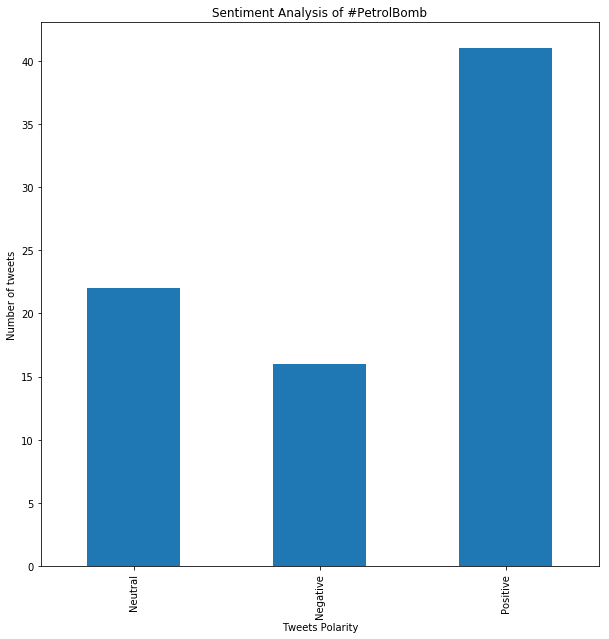

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10)) # define plot area
ax = fig.gca() # define axis    
A.plot(kind='bar',legend=False,ax = ax) # Use the plot.bar method on the counts data frame
ax.set_title('Sentiment Analysis of #PetrolBomb') # Give the plot a main title
ax.set_xlabel('Tweets Polarity') # Set text for the x axis
ax.set_ylabel('Number of tweets')# Set text for y axis

### 3.7 Word Embeddings (required for vectors to be used as features in modeling)
Word Embedding is the representation of text in the form of vectors. The underlying idea here is that similar words will have a minimum distance between their vectors.

Word2Vec models require a lot of text, so either we can train it on our training data or we can use the pre-trained word vectors developed by Google, Wiki, etc.